In [3]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
import requests

from bs4 import BeautifulSoup


In [51]:
file1 = open('cards-standard.txt', 'r') 
Lines = file1.readlines() 
maximum = len(Lines)
cards_key = {}
cards_value = {}
i=1
for line in Lines:
    cards_value[i] = line.rstrip("\n")
    cards_key[line.rstrip("\n")] = i
    i += 1

print(cards_key["Arcane Breath"])
print(cards_value[32])
print(len(Lines))

32
Arcane Breath
1254


In [306]:
deck_vector = [32,64,98,1000,1250,1,2,4,5,70,97,12,67,98,33,33,43,54,76,27,65,43,78,32,78,96,12,10,32,6]
print(len(deck_vector))

#no need to filter based of card class or legendaries etc.. because this is just for the conversion after the deck has been built. The actual filtering should be either done by the AI or previously done in the deckbuilding CSV

def deck_to_vector(deck):
    deck_vector = []
    for elem in deck:
        elem = elem.lstrip()
        deck_vector.append(cards_key[elem])
    return deck_vector

def vector_to_deck(deck_vector):
    deck = []
    for elem in deck_vector:
        deck.append(cards_value[elem])
    return deck

deck = vector_to_deck(deck_vector)
print(deck)

new_deck_vector = deck_to_vector(deck)
print(new_deck_vector)


30
['Arcane Breath', 'Demon Companion', 'Humility', 'Wrathspike Brute', 'Survival of the Fittest', 'Ancestral Healing', 'Backstab', 'Circle of Healing', 'Desk Imp', 'Double Jump', 'Hot Air Balloon', 'Lightning Bloom', 'Desperate Measures', 'Humility', 'Arcane Missiles', 'Arcane Missiles', 'Blessing of Might', 'Claw', 'Elemental Allies', 'Activate the Obelisk', 'Demonic Studies', 'Blessing of Might', 'Embalming Ritual', 'Arcane Breath', 'Embalming Ritual', 'Holy Smite', 'Lightning Bloom', 'Innervate', 'Arcane Breath', 'Embiggen']
[32, 64, 98, 1000, 1250, 1, 2, 4, 5, 70, 97, 12, 67, 98, 33, 33, 43, 54, 76, 27, 65, 43, 78, 32, 78, 96, 12, 10, 32, 6]


In [57]:
import random

def generate_fake_deck():
    deck = []
    for i in range(30):
        x = random.randint(1,maximum)
        deck.append(x)
    return deck

deck = generate_fake_deck()
deck = vector_to_deck(deck)
deck

['Dragonmaw Sky Stalker',
 'Hailbringer',
 'Hungry Crab',
 'Unidentified Contract',
 'Burly Shovelfist',
 'Hellfire',
 'Sludge Slurper',
 'Twisted Knowledge',
 'Turalyon, the Tenured',
 'Nature Studies',
 'Ritual Chopper',
 'Rocket Augmerchant',
 'Carnival Barker',
 "Dragon's Pack",
 "Ringmaster's Baton",
 'Blessing of Wisdom',
 'Blessing of Wisdom',
 'Vendetta',
 'Dire Wolf Alpha',
 'Young Priestess',
 'Altruis the Outcast',
 'Archivist Elysiana',
 'Darkglare',
 'Mindgames',
 'War Golem',
 'Faceless Manipulator',
 'Subdue',
 'Felfin Navigator',
 'Veranus',
 'Groundskeeper']

In [19]:

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model



In [7]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model


In [22]:
#generate a fake deck function
#function that collects a sample of decks from dataset
#function that filters the dataset based on the class selected
#function that converts decks into vectors and back into decks
#function that links generated GAN deck into simulator

#Equivalent generate latent points function for decks?
#how would I generate "fake" decks from the generator? 
# - The generator usually takes a noise vector from the latent dimension. How would I do that in my problem? Do I need to create a sort of histogram function that "encapsulates" a deck and all the cards from every data row are added to it, then the chosen deck highlights the points on the chart
#how would I convert the decks into vectors to feed into the Network? 
# - Maybe by creating a collection of cards and associate a key to their name and use those keys to create a vector of shape[30]
#Feeding vectors of decks should work right? 
#which of the examples should I base myself off? Are they both correct?


#Generate a random vector of 30 random cards. 
#Input of the neural network would be 30


# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # generate outputs X^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = ones((n, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
# generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y



In [9]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()


In [10]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)



1999 0.6899999976158142 0.5799999833106995


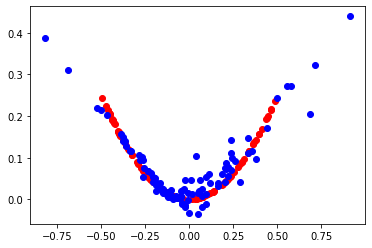

3999 0.6399999856948853 0.47999998927116394


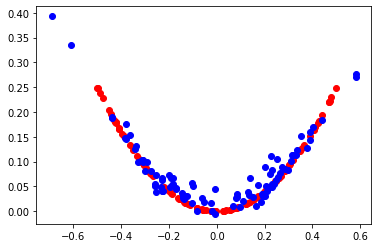

5999 0.6000000238418579 0.6000000238418579


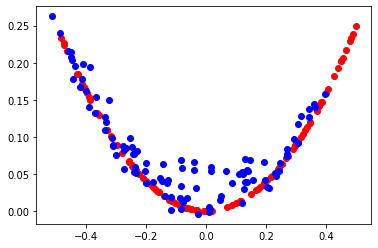

7999 0.5799999833106995 0.5899999737739563


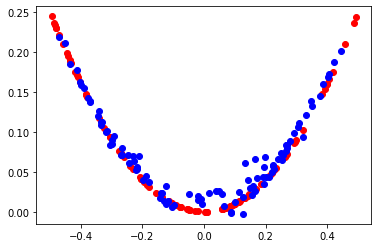

9999 0.6100000143051147 0.5699999928474426


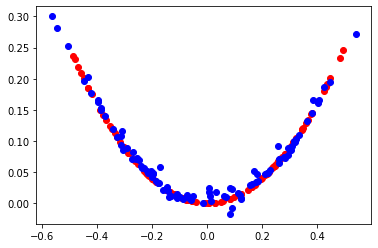

In [23]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [147]:
#scrape deck data from Hearthpwn website, standard decks
start_urls = []
for i in range(2):
    start_urls.append("https://www.hearthpwn.com/decks?filter-deck-tag=4&filter-show-constructed-only=y&filter-show-standard=1&page=" + str(i+1))
print(start_urls)
deck_urls = []
deck_classes = []
for url in start_urls:
    r = requests.get(url)
    soup = BeautifulSoup(r.content,"html.parser")
    #rows = soup.find(id="decks-container")
 
    rows = soup.find_all('table', class_="listing listing-decks b-table b-table-a")
    for row in rows:
        decks = row.find_all('span', class_="tip")
        for deck in decks:
            links = deck.find_all('a', href=True)
            for link in links:
                deck_urls.append("https://www.hearthpwn.com" + link['href'])
                
        deck_class = row.find_all('td', class_="col-class")
        for cl in deck_class:
            deck_classes.append(cl.text)

    
print(deck_urls[0])
print(len(deck_urls))
print(deck_classes)
print(len(deck_classes))


['https://www.hearthpwn.com/decks?filter-deck-tag=4&filter-show-constructed-only=y&filter-show-standard=1&page=1', 'https://www.hearthpwn.com/decks?filter-deck-tag=4&filter-show-constructed-only=y&filter-show-standard=1&page=2']
https://www.hearthpwn.com/decks/1372564-cthun-saron-control-68-wr-d5-legend
50
['Warrior', 'Shaman', 'Shaman', 'Warrior', 'Paladin', 'Hunter', 'Priest', 'Priest', 'Mage', 'Demon Hunter', 'Druid', 'Warlock', 'Priest', 'Priest', 'Paladin', 'Warlock', 'Rogue', 'Hunter', 'Hunter', 'Shaman', 'Shaman', 'Warlock', 'Rogue', 'Paladin', 'Warrior', 'Mage', 'Paladin', 'Shaman', 'Warrior', 'Rogue', 'Druid', 'Mage', 'Druid', 'Hunter', 'Mage', 'Priest', 'Demon Hunter', 'Druid', 'Priest', 'Mage', 'Warrior', 'Rogue', 'Rogue', 'Hunter', 'Shaman', 'Warrior', 'Priest', 'Shaman', 'Mage', 'Rogue']
50


In [183]:
#deck_array = [a + b for a,b in zip(deck_urls,deck_classes)]
#import numpy as np

#dl = np.asarray(deck_urls)
#dc = np.asarray(deck_classes)

#new_decks = np.hstack(zip(dl,dc))
#new_decks[1]

array = []
for i in range(len(deck_urls)):
    array.append([deck_urls[i],deck_classes[i]])
                  
print(array[0])
    

['https://www.hearthpwn.com/decks/1372564-cthun-saron-control-68-wr-d5-legend', 'Warrior']


In [184]:
#scrape cards in deck from separate url
decks = []
for url in deck_urls:
    deck=[]
    r = requests.get(url)
    soup = BeautifulSoup(r.content,"html.parser")
    table = soup.find_all('table', class_="listing listing-cards-tabular b-table b-table-a")
    for rows in table:
        row = rows.find_all('td', class_="col-name")
        for i in row:
            card = i.find('a')
            name = card.text
            number = card['data-count']
            
            for num in range(int(number)):
                deck.append(name.replace('\n',''))
    print(deck)
    print(len(deck))
    decks.append(deck)


        


['Risky Skipper', 'Risky Skipper', 'Shield Slam', 'Armorsmith', 'Armorsmith', 'Battle Rage', 'Battle Rage', 'Corsair Cache', 'Minefield', 'Minefield', 'Ancharrr', 'Bladestorm', 'Bladestorm', 'Bloodsworn Mercenary', 'Bulwark of Azzinoth', 'Coerce', 'EVIL Quartermaster', 'EVIL Quartermaster', 'Lord Barov', 'Shield Block', 'Shield Block', 'Sword Eater', 'Sword Eater', 'Brawl', 'Brawl', 'Deathwing, Mad Aspect', 'Rattlegore', 'Kobold Stickyfinger', "C'Thun, the Shattered", 'Yogg-Saron, Master of Fate']
30
['Lightning Bloom', 'Lightning Bloom', 'Mutate', 'Mutate', 'Revolve', 'Revolve', 'Cagematch Custodian', 'Cagematch Custodian', 'Diligent Notetaker', 'Diligent Notetaker', 'Explosive Evolution', 'Bogstrok Clacker', 'Bogstrok Clacker', 'Instructor Fireheart', 'Pit Master', 'Pit Master', 'Serpentshrine Portal', 'Serpentshrine Portal', 'Bloodlust', 'Boggspine Knuckles', 'Boggspine Knuckles', 'Totem Goliath', 'Totem Goliath', 'Mogu Fleshshaper', 'Mogu Fleshshaper', 'Desert Hare', 'Desert Hare',

['Raise Dead', 'Raise Dead', 'Demonic Studies', 'Demonic Studies', 'Flame Imp', 'Flame Imp', 'Soulfire', 'Soulfire', 'Voidwalker', 'Voidwalker', 'Boneweb Egg', 'Expired Merchant', 'Expired Merchant', 'Felstalker', 'Felstalker', 'Kanrethad Ebonlocke', 'Free Admission', 'Free Admission', "Man'ari Mosher", "Man'ari Mosher", 'Fire Breather', 'Fire Breather', 'Nightshade Matron', 'Nightshade Matron', "Hand of Gul'dan", "Hand of Gul'dan", 'Ring Matron', 'Ring Matron', 'Frenzied Felwing', 'Frenzied Felwing']
30
['Preparation', 'Preparation', 'Shadowstep', 'Pharaoh Cat', 'Pharaoh Cat', 'Praise Galakrond!', 'Praise Galakrond!', 'Foxy Fraud', 'Foxy Fraud', 'Swindle', 'Swindle', 'Edwin VanCleef', 'EVIL Miscreant', 'EVIL Miscreant', 'Seal Fate', 'Seal Fate', 'Ticket Master', 'Ticket Master', 'Jandice Barov', 'Malevolent Strike', 'Malevolent Strike', 'Stowaway', 'Stowaway', 'Flik Skyshiv', 'Heistbaron Togwaggle', 'Galakrond, the Nightmare', 'Shield of Galakrond', 'Shield of Galakrond', 'Kronx Drago

['Elemental Allies', 'Elemental Allies', 'Lab Partner', 'Lab Partner', 'Primordial Studies', 'Primordial Studies', 'Violet Spellwing', 'Violet Spellwing', 'Wand Thief', 'Wand Thief', 'Confection Cyclone', 'Confection Cyclone', 'Frostbolt', 'Frostbolt', 'Arcane Amplifier', 'Arcane Amplifier', 'Arcane Intellect', 'Arcane Intellect', 'Combustion', 'Firebrand', 'Firebrand', 'Flame Ward', 'Fireball', 'Fireball', 'Water Elemental', 'Water Elemental', 'Grand Finale', 'Grand Finale', 'Gyreworm', 'Gyreworm']
30
['Lightning Bloom', 'Nature Studies', 'Nature Studies', 'Strength in Numbers', 'Strength in Numbers', 'Breath of Dreams', 'Breath of Dreams', 'Guess the Weight', 'Guess the Weight', 'Lunar Eclipse', 'Lunar Eclipse', 'Bogbeam', 'Wild Growth', 'Wild Growth', 'Overgrowth', 'Overgrowth', 'Emerald Explorer', 'Emerald Explorer', 'Winged Guardian', 'Winged Guardian', 'Fizzy Elemental', 'Fizzy Elemental', 'Sphere of Sapience', 'Circus Amalgam', 'Claw Machine', 'Claw Machine', 'Evasive Drakonid',

['Lightning Bloom', 'Lightning Bloom', 'Totemic Might', 'Totemic Might', 'Totemic Surge', 'Totemic Surge', 'Sludge Slurper', 'Sludge Slurper', "Storm's Wrath", "Storm's Wrath", 'Surging Tempest', 'Surging Tempest', 'Cagematch Custodian', 'EVIL Totem', 'EVIL Totem', 'Trick Totem', 'Trick Totem', "Grand Totem Eys'or", 'Mana Tide Totem', 'Mana Tide Totem', 'Totemic Reflection', 'Totemic Reflection', 'Splitting Axe', 'Splitting Axe', 'Bloodlust', 'Totem Goliath', 'Tour Guide', 'Tour Guide', 'Circus Amalgam', 'Circus Amalgam']
30
['Devolving Missiles', 'Magic Trick', 'Wand Thief', 'Ancient Mysteries', 'Apexis Smuggler', 'Arcane Flakmage', 'Game Master', 'Starscryer', 'Counterspell', 'Firebrand', 'Flame Ward', 'Ice Barrier', 'Kirin Tor Mage', 'Netherwind Portal', 'Rigged Faire Game', 'Spellbender', 'Occult Conjurer', 'Ring Toss', 'Cloud Prince', 'Jandice Barov', 'Reno the Relicologist', 'Sayge, Seer of Darkmoon', 'The Amazing Reno', 'Acidic Swamp Ooze', 'Wandmaker', 'Zephrys the Great', 'Inc

In [308]:
len(decks)

vecks = []
for d in decks:
    vecks.append(deck_to_vector(d))


[[153,
  153,
  164,
  226,
  226,
  230,
  230,
  250,
  348,
  348,
  460,
  472,
  472,
  477,
  487,
  497,
  522,
  522,
  593,
  652,
  652,
  841,
  841,
  891,
  891,
  1163,
  1226,
  940,
  1232,
  1254],
 [12,
  12,
  14,
  14,
  151,
  151,
  242,
  242,
  265,
  265,
  285,
  480,
  480,
  576,
  619,
  619,
  645,
  645,
  887,
  888,
  888,
  990,
  990,
  1220,
  1220,
  511,
  511,
  731,
  731,
  764],
 [12,
  12,
  68,
  113,
  113,
  171,
  171,
  183,
  183,
  242,
  242,
  383,
  383,
  576,
  586,
  586,
  645,
  645,
  664,
  664,
  732,
  732,
  845,
  845,
  903,
  911,
  911,
  938,
  441,
  441],
 [36,
  36,
  100,
  100,
  170,
  170,
  178,
  178,
  241,
  241,
  274,
  378,
  378,
  655,
  655,
  778,
  778,
  841,
  841,
  174,
  174,
  235,
  235,
  287,
  287,
  361,
  361,
  777,
  777,
  782],
 [7,
  7,
  29,
  29,
  224,
  303,
  303,
  328,
  328,
  351,
  556,
  556,
  717,
  717,
  761,
  780,
  780,
  869,
  869,
  885,
  885,
  942,
  942,
  10

In [384]:
def concatenate_deck_class(decks, classes):
    concatenated_result = []
    for i in range(len(decks)):
        concatenated_result.append([decks[i],classes[i]])
    return concatenated_result

   
collected_decks = concatenate_deck_class(decks, deck_classes)
collected_decks_vectored = concatenate_deck_class(vecks, deck_classes)

print(collected_decks)
#collected_decks = []
#collected_decks_vectored = []
#for i in range(len(decks)):
 #   collected_decks.append([decks[i],deck_classes[i]]) #replace with vecks[i] for vectors 
  #  collected_decks_vectored.append([vecks[i],deck_classes[i]]) #replace with vecks[i] for vectors 

    
#print(collected_decks)
    

[[['Risky Skipper', 'Risky Skipper', 'Shield Slam', 'Armorsmith', 'Armorsmith', 'Battle Rage', 'Battle Rage', 'Corsair Cache', 'Minefield', 'Minefield', 'Ancharrr', 'Bladestorm', 'Bladestorm', 'Bloodsworn Mercenary', 'Bulwark of Azzinoth', 'Coerce', 'EVIL Quartermaster', 'EVIL Quartermaster', 'Lord Barov', 'Shield Block', 'Shield Block', 'Sword Eater', 'Sword Eater', 'Brawl', 'Brawl', 'Deathwing, Mad Aspect', 'Rattlegore', 'Kobold Stickyfinger', "C'Thun, the Shattered", 'Yogg-Saron, Master of Fate'], 'Warrior'], [['Lightning Bloom', 'Lightning Bloom', 'Mutate', 'Mutate', 'Revolve', 'Revolve', 'Cagematch Custodian', 'Cagematch Custodian', 'Diligent Notetaker', 'Diligent Notetaker', 'Explosive Evolution', 'Bogstrok Clacker', 'Bogstrok Clacker', 'Instructor Fireheart', 'Pit Master', 'Pit Master', 'Serpentshrine Portal', 'Serpentshrine Portal', 'Bloodlust', 'Boggspine Knuckles', 'Boggspine Knuckles', 'Totem Goliath', 'Totem Goliath', 'Mogu Fleshshaper', 'Mogu Fleshshaper', 'Desert Hare', '

In [386]:
import numpy as np
import pandas as pd


pd.DataFrame(collected_decks, columns=['cards', 'class']).to_csv("collected_decks.csv",index=False)
pd.DataFrame(collected_decks_vectored, columns=['cards', 'class']).to_csv("collected_decks_vectored.csv",index=False)


#reads a csv of vectored decks and returns a list of decks converted from vector to text
def read_vector_decks(file):
    df = pd.read_csv(file)
    cards_from_csv = df['cards']
    converted_decks = []
    for cards in cards_from_csv:
        deck_to_convert = []
        cards = cards.strip("[]")
        cards = cards.split(", ")
        for card in cards:
            deck_to_convert.append(int(card))
        converted_decks.append(vector_to_deck(deck_to_convert))
    class_from_csv = df['class']
    final = concatenate_deck_class(converted_decks, class_from_csv)
    return final

deck_list = read_vector_decks("collected_decks_vectored.csv")
print(deck_list[0])

#c = cards_from_csv[0].replace("[","") 
#c = c.replace("]","") 
#c = c.replace("'", "")
#print(deck_to_vector(c))
#c = c.strip('[]')
#c = c.split(", ")
#for i in cards_from_csv:
 #   print(deck_to_vector(i))
    

#new_df = deck_to_vector(df['cards'][0])

[['Risky Skipper', 'Risky Skipper', 'Shield Slam', 'Armorsmith', 'Armorsmith', 'Battle Rage', 'Battle Rage', 'Corsair Cache', 'Minefield', 'Minefield', 'Ancharrr', 'Bladestorm', 'Bladestorm', 'Bloodsworn Mercenary', 'Bulwark of Azzinoth', 'Coerce', 'EVIL Quartermaster', 'EVIL Quartermaster', 'Lord Barov', 'Shield Block', 'Shield Block', 'Sword Eater', 'Sword Eater', 'Brawl', 'Brawl', 'Deathwing, Mad Aspect', 'Rattlegore', 'Kobold Stickyfinger', "C'Thun, the Shattered", 'Yogg-Saron, Master of Fate'], 'Warrior']


In [422]:
classes = ['Warrior', 'Mage', 'Hunter', 'Priest', 'Druid', 'Rogue', 'Shaman', 'Warlock', 'Paladin', 'Demon Hunter']

class_dictionary = {}

def filter_class(class_):
    filtered_decks = []
    for deck in deck_list:
        if deck[1] == class_:
            filtered_decks.append(deck)
    return filtered_decks

for class_ in classes:
    class_dictionary[class_] = filter_class(class_)
    #print(filtered_decks)        

Warrior: 6
Mage: 6
Hunter: 5
Priest: 7
Druid: 4
Rogue: 6
Shaman: 7
Warlock: 3
Paladin: 4
Demon Hunter: 2


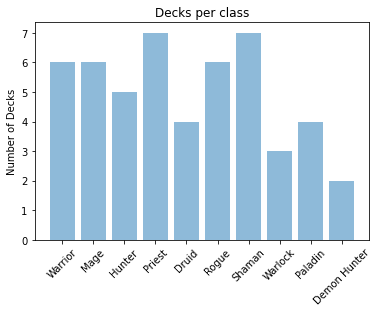

In [424]:
import numpy as np
import matplotlib.pyplot as plt

performance = []
#number of decks of each class
for class_ in classes:
    performance.append(len(class_dictionary[class_]))
    print(class_ + ": " + str(len(class_dictionary[class_])))


y_pos = np.arange(len(classes))
plt.bar(y_pos, performance, align="center", alpha=0.5)
plt.xticks(y_pos, classes, rotation = 45)
plt.ylabel('Number of Decks')
plt.title('Decks per class')
plt.show()